In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [44.8 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,400 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB]
Hit:13 https://ppa.launchpadc

In [79]:
# Import packages
from pyspark.sql import SparkSession
import time
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [34]:
from pyspark import SparkFiles
url = "https://nduffee-project4.s3.us-west-2.amazonaws.com/WMdata_with_holidays.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("WMdata_with_holidays.csv"), header= True, inferSchema= True)

# show the dataframe
df.show()

+---+-----+---------+------------+------------+-----------+----------+-----------+------------+---------------+
| id|Store|     Date|Weekly_Sales|Holiday_Flag|Temperature|Fuel_Price|        CPI|Unemployment|   Holiday_Name|
+---+-----+---------+------------+------------+-----------+----------+-----------+------------+---------------+
|  0|    1| 2/5/2010|   1643690.9|           0|      42.31|     2.572|211.0963582|       8.106|           NULL|
|  1|    1|2/12/2010|  1641957.44|           1|      38.51|     2.548|211.2421698|       8.106|Valentine's Day|
|  2|    1|2/19/2010|  1611968.17|           0|      39.93|     2.514|211.2891429|       8.106|           NULL|
|  3|    1|2/26/2010|  1409727.59|           0|      46.63|     2.561|211.3196429|       8.106|           NULL|
|  4|    1| 3/5/2010|  1554806.68|           0|       46.5|     2.625|211.3501429|       8.106|           NULL|
|  5|    1|3/12/2010|  1439541.59|           0|      57.79|     2.667|211.3806429|       8.106|         

In [35]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView("Sales")


In [36]:
# Sales Total over the period?
spark.sql("""
SELECT ROUND((SUM(Weekly_Sales)) / 1000000000, 2) AS Total_Sales_Billions
FROM Sales
""").show()

+--------------------+
|Total_Sales_Billions|
+--------------------+
|                6.74|
+--------------------+



In [37]:
# Average Sales over the period?
spark.sql("""
SELECT ROUND(AVG(Weekly_Sales), 2) AS AVG_Sales
FROM Sales
""").show()

+----------+
| AVG_Sales|
+----------+
|1046964.88|
+----------+



In [45]:
# Which Store has the most Sales Overall?
Top_Stores = spark.sql("""
SELECT Store, ROUND((SUM(Weekly_Sales)) / 1000000, 2) AS Sales_Total_Millions
FROM Sales
GROUP BY Store
ORDER BY SUM(Weekly_Sales) DESC
LIMIT 10;
    """)

Top_Stores.show()

+-----+--------------------+
|Store|Sales_Total_Millions|
+-----+--------------------+
|   20|               301.4|
|    4|              299.54|
|   14|               289.0|
|   13|              286.52|
|    2|              275.38|
|   10|              271.62|
|   27|              253.86|
|    6|              223.76|
|    1|               222.4|
|   39|              207.45|
+-----+--------------------+



In [46]:
# Which Store had the lowest Sales Overall?
Lowest_Stores = spark.sql("""
SELECT Store, ROUND((SUM(Weekly_Sales) / 1000000), 2) AS Sales_Total_Millions
FROM Sales
GROUP BY Store
ORDER BY SUM(Weekly_Sales)
LIMIT 10;
    """)

Lowest_Stores.show()

+-----+--------------------+
|Store|Sales_Total_Millions|
+-----+--------------------+
|   33|               37.16|
|   44|               43.29|
|    5|               45.48|
|   36|               53.41|
|   38|               55.16|
|    3|               57.59|
|   30|               62.72|
|   37|                74.2|
|   16|               74.25|
|   29|               77.14|
+-----+--------------------+



In [40]:
# What was the highest weekly Sales Total?
spark.sql("""
SELECT Store, Date, max(Weekly_Sales)
FROM Sales
GROUP BY Store, Date
ORDER BY max(Weekly_Sales) DESC
LIMIT 1
""").show()

+-----+----------+-----------------+
|Store|      Date|max(Weekly_Sales)|
+-----+----------+-----------------+
|   14|12/24/2010|       3818686.45|
+-----+----------+-----------------+



In [47]:
# Which Store has the highest standard Deviation
Std_Dev = spark.sql("""
SELECT Store, ROUND(STDDEV(Weekly_Sales), 2) AS STDDEV
From Sales
GROUP BY Store
ORDER BY STDDEV(Weekly_Sales) DESC
LIMIT 5
""")

Std_Dev.show()

+-----+---------+
|Store|   STDDEV|
+-----+---------+
|   14|317569.95|
|   10|302262.06|
|   20|275900.56|
|    4|266201.44|
|   13| 265507.0|
+-----+---------+



In [48]:
# Which Store has the largest Range?
Store_Range = spark.sql("""
SELECT Store, ROUND((MAX(Weekly_Sales) - MIN(Weekly_Sales)), 2) AS Range
FROM Sales
GROUP BY Store
ORDER BY ROUND((MAX(Weekly_Sales) - MIN(Weekly_Sales)), 2) DESC
LIMIT 5
""")

Store_Range.show()

+-----+----------+
|Store|     Range|
+-----+----------+
|   14|2339171.79|
|   10|2121350.38|
|   20|2005670.92|
|   13|1962240.08|
|    4|1913849.68|
+-----+----------+



In [49]:
# What were the best weeks for Sales?
Best_Weeks = spark.sql("""
SELECT Date, ROUND(SUM(Weekly_Sales) / 1000000, 2) AS Total_Sales_Millions
FROM Sales
GROUP BY Date
ORDER BY SUM(Weekly_Sales) DESC
LIMIT 10
""")

Best_Weeks.show()

+----------+--------------------+
|      Date|Total_Sales_Millions|
+----------+--------------------+
|12/24/2010|               80.93|
|12/23/2011|                77.0|
|11/25/2011|               66.59|
|11/26/2010|               65.82|
|12/17/2010|               61.82|
|12/16/2011|               60.09|
|12/10/2010|               55.67|
| 12/9/2011|               55.56|
|  4/6/2012|                53.5|
|  7/6/2012|               51.25|
+----------+--------------------+



In [50]:
# Holidays vs Normal AVG Sales
Holiday_NotHoliday = spark.sql("""
SELECT Holiday_Flag, ROUND(AVG(Weekly_Sales), 2) AS Avg
FROM Sales
GROUP BY Holiday_Flag
ORDER BY AVG DESC
""")

Holiday_NotHoliday.show()

+------------+----------+
|Holiday_Flag|       Avg|
+------------+----------+
|           1|1122887.89|
|           0|1041256.38|
+------------+----------+



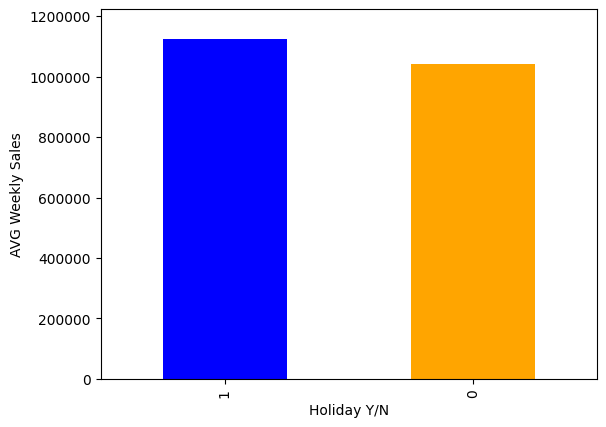

In [95]:
# Graph Holidays vs Not Holidays AVG Price
pandas_holiday = Holiday_NotHoliday.toPandas()
pandas_holiday.plot(kind='bar', x='Holiday_Flag', y='Avg', legend=None, color=['blue', 'orange'])
plt.ylabel("AVG Weekly Sales")
plt.xlabel("Holiday Y/N")
max_y_lim = max(pandas_holiday['Avg']) + 100000
plt.ylim(0, max_y_lim)
plt.show()


In [96]:
# Does Fuel Price Affect Average Weekly Sales?
Fuel_Prices = spark.sql("""SELECT Fuel_Price, AVG(Weekly_Sales) AS Avg_Weekly_Sales
FROM Sales
GROUP BY Fuel_Price
ORDER BY Fuel_Price""")

Fuel_Prices.show()

+----------+------------------+
|Fuel_Price|  Avg_Weekly_Sales|
+----------+------------------+
|     2.472|         470281.03|
|     2.513|         434471.38|
|     2.514|1015099.2707142858|
|      2.52|         447519.44|
|     2.533|         431294.45|
|     2.539|          469563.7|
|      2.54|       1516911.665|
|     2.542|          452021.2|
|     2.545|         467546.74|
|     2.548|1040743.7442857145|
|      2.55|         713183.45|
|     2.561| 891811.9746666667|
|     2.562|         412050.73|
|     2.565| 923341.2999999999|
|     2.567|         422169.47|
|     2.572| 953758.7210526317|
|     2.573|1216787.1066666667|
|     2.574|1092755.0666666667|
|     2.577| 956875.7157142857|
|     2.578|         419348.59|
+----------+------------------+
only showing top 20 rows



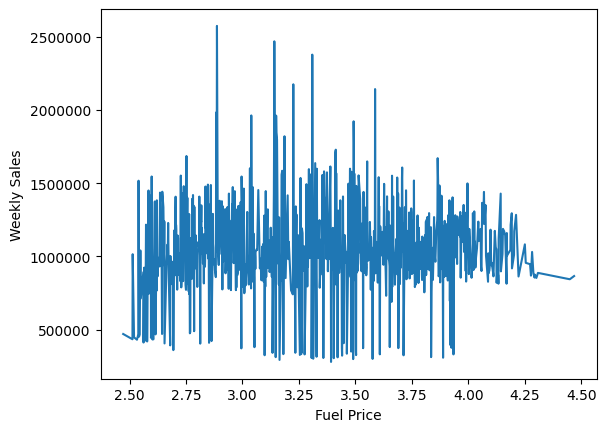

In [97]:
# Graphing Fuel Prices vs Weekly Sales
pandas_fuel = Fuel_Prices.toPandas()
pandas_fuel.plot(kind='line', x='Fuel_Price', y='Avg_Weekly_Sales', legend=None)
plt.ticklabel_format(style='plain')
plt.ylabel("Weekly Sales")
plt.xlabel("Fuel Price")
plt.show()

In [98]:
# Does the temperature affect Avg Weekly Sales?
Temp = spark.sql("""SELECT Temperature, AVG(Weekly_Sales) AS AVG_Weekly_Sales
FROM Sales
GROUP BY Temperature
ORDER BY Temperature""")

Temp.show()

+-----------+----------------+
|Temperature|AVG_Weekly_Sales|
+-----------+----------------+
|      -2.06|       558027.77|
|       5.54|       817485.14|
|       6.23|      1083071.14|
|       7.46|       593875.46|
|       9.51|       775910.43|
|       9.55|      1034119.21|
|      10.09|       661163.94|
|      10.11|       513372.17|
|      10.24|       559903.13|
|      10.53|       496725.44|
|      10.91|      1083657.61|
|      11.17|      782826.235|
|      11.29|       816603.05|
|      11.32|        547384.9|
|      12.19|      1059715.27|
|      12.39|       573545.96|
|      12.98|       809833.21|
|      13.29|       904261.65|
|      13.64|       479263.15|
|      13.76|       729572.08|
+-----------+----------------+
only showing top 20 rows



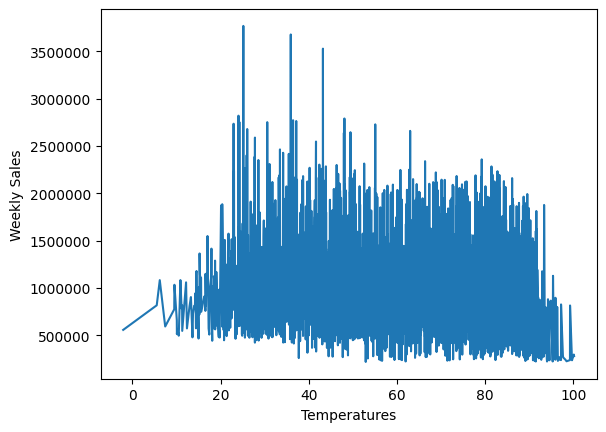

In [101]:
# Graphing Temperature vs Weekly Sales
pandas_temp = Temp.toPandas()
pandas_temp.plot(kind='line', x='Temperature', y='AVG_Weekly_Sales', legend=None)
plt.ticklabel_format(style='plain')
plt.ylabel("Weekly Sales")
plt.xlabel("Temperatures")
plt.show()

In [105]:
# Does Consumer Price Index (CPI) affect Avg Weekly Sales?
cpi = spark.sql("""SELECT CPI, AVG(Weekly_Sales) AS AVG_Weekly_Sales
FROM Sales
GROUP BY CPI
ORDER BY CPI""")

cpi.show()

+-----------+------------------+
|        CPI|  AVG_Weekly_Sales|
+-----------+------------------+
|    126.064|1016970.2372727274|
|126.0766452|1021503.8372727274|
|126.0854516|1056102.1872727273|
|126.0892903| 967673.0554545454|
|126.1019355|1040634.7172727275|
|126.1069032| 958498.2536363639|
|126.1119032|1042786.9809090908|
|    126.114|1022294.3090909091|
|126.1145806|1011128.5600000002|
|   126.1266| 992548.5681818182|
|126.1283548| 987833.2418181818|
|126.1360645|        1072110.06|
|   126.1392|1037458.3827272728|
|126.1454667| 961378.7172727273|
|126.1498065|1007496.7563636363|
|   126.1518| 998326.2636363636|
|126.1602258| 997176.3581818183|
|126.1843871| 993435.8781818182|
|126.1900333| 926515.1736363637|
|126.2085484|1005615.5127272728|
+-----------+------------------+
only showing top 20 rows



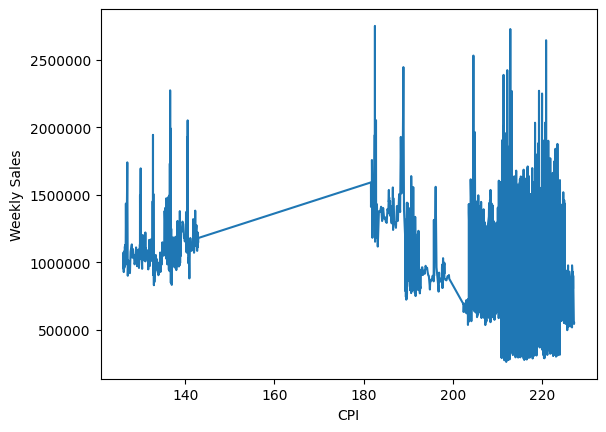

In [107]:
# Graph CPI vs Avg Weekly Sales
pandas_cpi = cpi.toPandas()
pandas_cpi.plot(kind='line', x='CPI', y='AVG_Weekly_Sales', legend=None)
plt.ticklabel_format(style='plain')
plt.ylabel("Weekly Sales")
plt.xlabel("CPI")
plt.show()

In [106]:
# Does unemployment affect Avg Weekly Sales?
unemployment = spark.sql("""SELECT Unemployment, AVG(Weekly_Sales) AS AVG_Weekly_Sales
FROM Sales
GROUP BY Unemployment
ORDER BY Unemployment""")

unemployment.show()

+------------+------------------+
|Unemployment|  AVG_Weekly_Sales|
+------------+------------------+
|       3.879|2147430.7024999997|
|       4.077| 2138214.804615385|
|       4.125|1200639.2442307693|
|       4.145|1184902.8099999998|
|       4.156|1212103.2507692308|
|       4.261|1066533.0284615385|
|       4.308|2188797.2053846153|
|        4.42|1354221.0473076922|
|       4.584|1182792.5985714286|
|       4.607|2148485.4076923076|
|       4.781|1147272.1065384613|
|       4.954|       564240.2625|
|       5.114|1019044.2483333332|
|       5.124| 923982.2999999999|
|       5.143| 2421417.686153846|
|       5.217|340005.10250000004|
|       5.277| 540165.3507692307|
|       5.287|1268310.8871428573|
|       5.326|1162200.9815384618|
|       5.329|        1461471.22|
+------------+------------------+
only showing top 20 rows



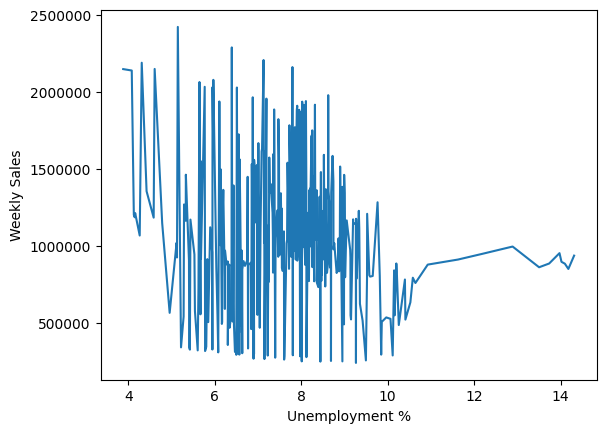

In [109]:
# Graph Umemployment vs Avg Weekly Sales
pandas_umemployment = unemployment.toPandas()
pandas_umemployment.plot(kind='line', x='Unemployment', y='AVG_Weekly_Sales', legend=None)
plt.ticklabel_format(style='plain')
plt.ylabel("Weekly Sales")
plt.xlabel("Unemployment %")
plt.show()